In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 1. Các thư viện cần thiết
!pip install pydlm
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pydlm import dlm, trend, dynamic
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.2 MB/s eta 0:00:00


In [3]:
# 2. Đọc file dữ liệu và chia train test validate theo tỉ lệ
df = pd.read_csv('/content/drive/MyDrive/Project_dataset/HPG.csv')
df = df[['Price','Low']]

df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validating sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

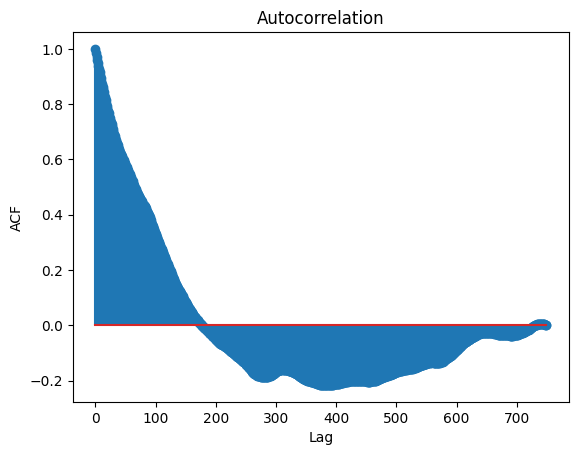

In [14]:
# 3. Tính toán ACF
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data['Price'], nlags= 1000)

# Vẽ đồ thị ACF
plt.stem(acf)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation')
plt.show()

In [5]:
# 4. Quá trình training
y_train = np.array(train_data['Price'])

x_train = []
for data in train_data['Low']:
  x_train.append([data])

model = dlm(y_train)
model = model + trend(1, discount=0.99, name='Trend', w=1e7)
model = model + dynamic(features=x_train, discount=1, name='Low')
model = model + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model = model + longSeason(period=12, stay=30, data=y_train, name='season', w=1e7)


model.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [6]:
# 5. Quá trình testing
x_test= []
for data in test_data['Low']:
  x_test.append([data])

y_test = np.array(test_data['Price'])

y_pred = model.predictN(date = model.n-1, N=len(x_test),featureDict={'Low': x_test})
y_pred = y_pred[0]


In [7]:
# 6. Quá trình Validate
x_val= []
for data in val_data['Low']:
  x_val.append([data])

y_val = np.array(val_data['Price'])

y_pred_val = model.predictN(featureDict={'Low': x_val}, N = len(x_val))
y_pred_val = y_pred_val[0]


In [8]:
# 7. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mae = np.mean(np.abs(y_pred - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 9533.327546936202
Testing RMSE: 9759.23715032263
Validation MAPE: 46.36078940810642
Testing MAPE: 34.98541980186304
Validation MAE: 9506.630209537716
Testing MAE: 8151.120054698441


In [9]:
#  8. Sử dụng linear regression dự báo cột Low 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])


# Predict the prices for the next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

index_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
low_next_30_days = ln_model.predict(index_next_30_days)

print(low_next_30_days)


[29373.83664964 29391.07395557 29408.31126151 29425.54856744
 29442.78587337 29460.0231793  29477.26048523 29494.49779117
 29511.7350971  29528.97240303 29546.20970896 29563.4470149
 29580.68432083 29597.92162676 29615.15893269 29632.39623863
 29649.63354456 29666.87085049 29684.10815642 29701.34546235
 29718.58276829 29735.82007422 29753.05738015 29770.29468608
 29787.53199202 29804.76929795 29822.00660388 29839.24390981
 29856.48121574 29873.71852168]


In [10]:
# 9. Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days = []
for data in low_next_30_days:
  x_next_30_days.append([data])

y_next_30_days = model.predictN(N = 30, featureDict={'Low': x_next_30_days})
y_next_30_days = y_next_30_days[0]
print(y_next_30_days)


[33323.940552260174, 35611.7529778512, 34406.72835174494, 34745.506468395266, 34665.93650284794, 34716.94785670387, 34744.880047322884, 34776.56532135701, 34809.34245700414, 34841.37688566458, 34873.81994941859, 34906.1206959791, 34938.4708114997, 34970.808180063774, 35003.14863893842, 35035.488729581084, 35067.82877231722, 35100.16889430434, 35132.50897839229, 35164.84907796037, 35197.1891725681, 35229.52926863093, 35261.869364365455, 35294.20946015443, 35326.54955594684, 35358.889651732396, 35391.22974752184, 35423.56984330973, 35455.90993909817, 35488.25003488644]


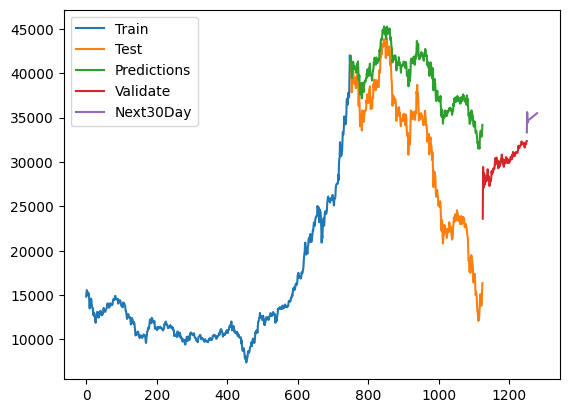

In [11]:
# 10. Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()